In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random
import math
random.seed(256)

from __future__ import division, print_function, absolute_import

import tensorflow as tf
import tflearn
from tflearn.data_utils import shuffle, to_categorical
from tflearn.layers.core import input_data, dropout, fully_connected, flatten
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation
from tflearn.layers.normalization import local_response_normalization

from bbox_predict import *

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

ERROR:tornado.application:Exception in callback functools.partial(<function wrap.<locals>.null_wrapper at 0x7f8232871ae8>)
Traceback (most recent call last):
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/ioloop.py", line 600, in _run_callback
    ret = callback()
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 242, in enter_eventloop
    self.eventloop(self)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/eventloops.py", line 163, in loop_tk
    kernel.timer = Timer(doi)
  File "/home/cs231n/myVE35/lib/python3.5/site-packages/ipykernel/eventloops.py", line 151, in __init__
    self.app = Tk()
  File "/usr/lib/python3.5/tkinter/__init__.py", line 1871, in __init__
    self.tk = _tkinter.create(screenName, baseName, className, interactive, wantobjects, useTk, sync, use)
_tkint

In [2]:
# with open("../datasets/sample_train_batch", "rb") as f:
with open("../datasets/train_batch_bbox", "rb") as f:
    data_dict = pickle.load(f)
#     X = data_dict['data'].transpose([0, 3, 1, 2])
    X = data_dict['data'].astype('float32')
    Y = data_dict['label']
    bbox = data_dict['bbox'].astype('float32')
    print((X.shape, Y.shape, bbox.shape))

Y = Y - 1
X, Y, bbox = shuffle(X, Y, bbox)
Y = to_categorical(Y, 3)   

N_train = math.floor(X.shape[0] * 0.8)
N_val = X.shape[0] - N_train
ix = [i for i in range(X.shape[0])]
random.shuffle(ix)

train_ix = ix[:N_train]
val_ix = ix[N_train:]
# print(val_ix)

X_train = X[train_ix]
y_train = Y[train_ix]
X_train_bbox = bbox[train_ix]
X_val = X[val_ix]
y_val = Y[val_ix]
X_val_bbox = bbox[val_ix]

((1480, 256, 256, 3), (1480,), (1480, 4))


In [113]:
class bbox_resnet():
    def __init__(self, config):
        self.config = config
#         tf.reset_default_graph()
        self.add_placeholder()
        self.net = self.add_model()
        self.pred_bbox = self.predict()
        self.total_loss, self.bbox_loss = self.add_loss()
        self.train_op = self.add_train_op()
        self.train_total_loss_hist = list()
        self.train_bbox_loss_hist = list()
        self.val_bbox_loss_hist = list()
        
        
    def add_placeholder(self):
        # Building Residual Network
#         self.model_input = tflearn.input_data(shape=[None, 256, 256, 3])
        # each row in box is 4-d with (x,y,w,h) all four number are between 0 and 255
        self.bbox = tf.placeholder(tf.float32, shape=[None, 4])
        self.model_input = tf.placeholder(tf.float32, shape=[None, 256, 256, 3])
        # net = tflearn.input_data(shape=[None, 256, 256, 3])
        
        
    def add_model(self):    
        n = self.config.n
        net = tflearn.conv_2d(self.model_input,16, 7)
#         net = tflearn.conv_2d(self.model_input, 16, 7, regularizer='L2', strides=2, weight_decay=0.0001)
        net = tflearn.max_pool_2d(net, 3, strides = [1, 2, 2, 1])
        net = tflearn.residual_block(net, n[0], 64)
        net = tflearn.residual_block(net, 1, 128, downsample=True)
        net = tflearn.residual_block(net, n[1] - 1, 128)
        net = tflearn.residual_block(net, 1, 256, downsample=True)
        net = tflearn.residual_block(net, n[2] - 1, 256)
        net = tflearn.residual_block(net, 1, 512, downsample=True)
        net = tflearn.residual_block(net, n[3] - 1, 512)
        net = tflearn.batch_normalization(net)
        net = tflearn.activation(net, 'relu')
        net = tflearn.global_avg_pool(net)
        net = fully_connected(net, 128, activation='relu')
        net = dropout(net, 0.8)
        # Regression
        return net
        
    def predict(self):    
        net = self.net
#         pred_bbox_raw = fully_connected(net, 4, activation='tanh')
#         pred_bbox = 125.0 + 125.0 * pred_bbox_raw
        pred_bbox_raw = fully_connected(net, 4, activation='sigmoid')
        pred_bbox = 250.0 * pred_bbox_raw
#         pred_bbox_raw = tf.maximum(pred_bbox_raw, 10.0)
#         pred_bbox = pred_bbox_raw - tf.maximum(pred_bbox_raw-256.0, 0.0)
        return pred_bbox
        
    
    def add_loss(self): 
        bbox = self.bbox
        pred_bbox = self.pred_bbox
        tx = (pred_bbox[:,0] - bbox[:,0])/bbox[:,2]
        ty = (pred_bbox[:,1] - bbox[:,1])/bbox[:,3]
        tw = tf.log(pred_bbox[:,2]/bbox[:,2])
        th = tf.log(pred_bbox[:,3]/bbox[:,3])
        
        bbox_loss = 0.5 * tf.reduce_mean(tf.square(tx) + tf.square(ty) + tf.square(tw) + tf.square(th))
        l2_loss = 0.0 
        for v in tf.trainable_variables():
            l2_loss += tf.nn.l2_loss(v)
        
        total_loss = bbox_loss + self.config.l2 * l2_loss
        return (total_loss, bbox_loss)
    
    def add_train_op(self):
#         optimizer = tf.train.RMSPropOptimizer(self.config.lr)
#         optimizer = tf.train.RMSPropOptimizer(self.config.lr)
        optimizer = tf.train.AdamOptimizer(self.config.lr)
        return optimizer.minimize(self.total_loss)
    
    def run_epoch(self, sess, X_train, X_train_bbox, X_val, X_val_bbox):
        num_train = int(X_train.shape[0])
        batch_size = self.config.batch_size
        num_steps = num_train // batch_size
        train_ix = np.random.permutation(num_train)
        train_pred_bbox = np.zeros_like(X_train_bbox)
        for i in range(num_steps):
#             ix = range(i * batch_size, min((i+1) * batch_size, num_train))
            ix = train_ix[i * batch_size: min((i+1) * batch_size, num_train)]
            pred_bbox, total_loss, bbox_loss, _  = sess.run([self.pred_bbox, self.total_loss, self.bbox_loss, self.train_op], 
                                                 feed_dict = {self.model_input: X_train[ix], self.bbox: X_train_bbox[ix]})
            self.train_total_loss_hist.append(total_loss)
            self.train_bbox_loss_hist.append(bbox_loss)
            train_pred_bbox[ix] = pred_bbox
            if i % 10 == 0:
                print("Step %d, total loss %f, bbox loss %f"%(i, total_loss, bbox_loss))
        
        num_val = int(X_val.shape[0])
        num_val_steps = num_val // batch_size
        val_pred_bbox = np.zeros_like(X_val_bbox)
        current_loss = 0.0
        for i in range(num_val_steps):
            ix = range(i * batch_size, min((i+1) * batch_size, num_val))
            pred_bbox, bbox_loss = sess.run([self.pred_bbox, self.bbox_loss], 
                                            feed_dict = {self.model_input: X_val[ix], self.bbox: X_val_bbox[ix]})
            val_pred_bbox[ix] = pred_bbox
            current_loss += bbox_loss
#             self.val_bbox_loss_hist.append(bbox_loss)
#             print("Validation loss %f"%(bbox_loss))
        current_loss /= (num_val_steps)
        self.val_bbox_loss_hist.append(current_loss)
        print("Validation loss %f"%(current_loss))
        return (train_pred_bbox, val_pred_bbox)
            
    def run_prediction(self, sess, X_test):
        num_test = int(X_test,shape[0])
        batch_size = self.config.batch_size
        num_steps = num_train // batch_size
        pred_bbox = list()
        for i in range(num_steps):
            ix = range(i * batch_size, min((i+1) * batch_size, num_test))
            bbox = sess.run([self.pre_bbox], feed_dict = {self.model_input: X_test})
            pred_bbox = pred_bbox + bbox
        return pred_bbox

In [114]:
class Config():
    lr = 1e-6
    l2 = 1e-5
    n = [1, 1, 1, 1]
    batch_size = 32

In [115]:
config = Config()

In [116]:
model = bbox_resnet(config)

In [117]:
epochs = 25
sess = tf.Session()

In [118]:
sess.run(tf.global_variables_initializer())
for i in range(epochs):
    train_pred_bbox, pred_bbox = model.run_epoch(sess, X_train, X_train_bbox, X_val, X_val_bbox)

Step 0, total loss 1.118099, bbox loss 1.001333
Step 10, total loss 2.096767, bbox loss 1.980021
Step 20, total loss 1.045460, bbox loss 0.928740
Step 30, total loss 0.952298, bbox loss 0.835604
Validation loss 0.960869
Step 0, total loss 0.962984, bbox loss 0.846309
Step 10, total loss 0.997525, bbox loss 0.880878
Step 20, total loss 1.709669, bbox loss 1.593049
Step 30, total loss 0.765893, bbox loss 0.649302
Validation loss 0.654111
Step 0, total loss 0.808633, bbox loss 0.692061
Step 10, total loss 2.150952, bbox loss 2.034408
Step 20, total loss 14.546381, bbox loss 14.429866
Step 30, total loss 0.522602, bbox loss 0.406115
Validation loss 0.628138
Step 0, total loss 0.732330, bbox loss 0.615864
Step 10, total loss 0.540734, bbox loss 0.424297
Step 20, total loss 0.621678, bbox loss 0.505270
Step 30, total loss 0.912452, bbox loss 0.796073
Validation loss 0.464353
Step 0, total loss 0.484674, bbox loss 0.368315
Step 10, total loss 0.734997, bbox loss 0.618667
Step 20, total loss 0

In [94]:
for i in range(5):
    train_pred_bbox, pred_bbox = model.run_epoch(sess, X_train, X_train_bbox, X_val, X_val_bbox)

Step 0, total loss 0.790438, bbox loss 0.703666
Step 10, total loss 0.567092, bbox loss 0.480340
Step 20, total loss 0.389811, bbox loss 0.303079
Step 30, total loss 0.518333, bbox loss 0.431622
Validation loss 0.530767
Step 0, total loss 0.637062, bbox loss 0.550364
Step 10, total loss 1.334394, bbox loss 1.247716
Step 20, total loss 0.416538, bbox loss 0.329879
Step 30, total loss 0.476525, bbox loss 0.389887
Validation loss 0.459923
Step 0, total loss 0.344397, bbox loss 0.257772
Step 10, total loss 2.164302, bbox loss 2.077698
Step 20, total loss 0.409860, bbox loss 0.323275
Step 30, total loss 0.397229, bbox loss 0.310664
Validation loss 0.477158
Step 0, total loss 0.690380, bbox loss 0.603829
Step 10, total loss 1.794512, bbox loss 1.707981
Step 20, total loss 0.505279, bbox loss 0.418768
Step 30, total loss 0.551779, bbox loss 0.465287
Validation loss 0.445937
Step 0, total loss 0.518660, bbox loss 0.432182
Step 10, total loss 0.511531, bbox loss 0.425073
Step 20, total loss 0.5

In [101]:
for i in range(5):
    train_pred_bbox, pred_bbox = model.run_epoch(sess, X_train, X_train_bbox, X_val, X_val_bbox)

Step 0, total loss 0.494515, bbox loss 0.408111
Step 10, total loss 1.371234, bbox loss 1.284849
Step 20, total loss 0.551319, bbox loss 0.464954
Step 30, total loss 0.406016, bbox loss 0.319672
Validation loss 0.439651
Step 0, total loss 0.326009, bbox loss 0.239678
Step 10, total loss 0.467804, bbox loss 0.381493
Step 20, total loss 1.682526, bbox loss 1.596235
Step 30, total loss 0.463118, bbox loss 0.376846
Validation loss 0.436851
Step 0, total loss 0.295173, bbox loss 0.208916
Step 10, total loss 0.423466, bbox loss 0.337228
Step 20, total loss 0.403327, bbox loss 0.317109
Step 30, total loss 0.547260, bbox loss 0.461061
Validation loss 0.483605
Step 0, total loss 0.382727, bbox loss 0.296543
Step 10, total loss 0.321419, bbox loss 0.235254
Step 20, total loss 2.346688, bbox loss 2.260543
Step 30, total loss 0.699726, bbox loss 0.613601
Validation loss 0.474335
Step 0, total loss 0.496998, bbox loss 0.410886
Step 10, total loss 0.447344, bbox loss 0.361252
Step 20, total loss 0.3

In [15]:
import matplotlib.patches as patches
from PIL import Image
%matplotlib inline 

def change_channel(img, new_channel = [0,1,2], normalize = False):
    image = img.astype('uint8')
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
#     image = img.astype('uint8')
    new_image = np.zeros_like(image)
    for i in range(len(new_channel)):
        new_image[:,:,i] = image[:,:,new_channel[i]]
    return new_image    




[133 108 115 113]
[124 122 146 133]


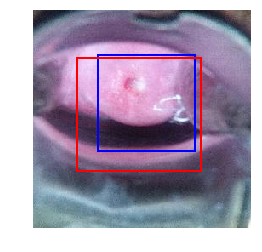

In [125]:
# im = np.array(Image.open('stinkbug.png'), dtype=np.uint8)
i = 5
# img = change_channel(A[i])
# bbox = C[i].astype('int')
img = change_channel(X_train[i])
box = X_val_bbox[i].astype('int')
box_pred = pred_bbox[i].astype('int')
print(box)
print(box_pred)
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)
x = box[0]- box[2]/2 
y = box[1] - box[3]/2
w = box[2]
h = box[3]

x1 = box_pred[0]- box_pred[2]/2 
y1 = box_pred[1] - box_pred[3]/2
w1 = box_pred[2]
h1 = box_pred[3]
# Create a Rectangle patch
# rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='b',facecolor='none')
rect = patches.Rectangle((x,y), w, h,linewidth=2,edgecolor='b',facecolor='none')
rect_pred = patches.Rectangle((x1,y1), w1, h1,linewidth=2,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
ax.add_patch(rect_pred)
plt.gca().axis('off')

plt.show()



In [126]:
train_loss = model.train_bbox_loss_hist
train_total_loss = model.train_total_loss_hist

In [127]:
val_loss = model.val_bbox_loss_hist

In [70]:
plt.style.use('ggplot')

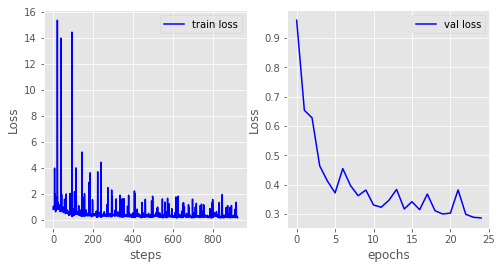

In [128]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(range(len(train_loss)), train_loss, "b-", label="train loss")
# ax1.plot(range(len(train_total_loss)), train_total_loss, "g--", label="train total loss", linewidth=0.5)
ax2.plot(range(len(val_loss)), val_loss, "b-", label="val loss")

# specify
# ax1.set_xlim([0, 850])
# ax1.set_ylim([0,4])
# ax2.set_xlim([0, 23])
ax1.set_xlabel("steps")
ax1.set_ylabel("Loss")
ax2.set_xlabel("epochs")
ax2.set_ylabel("Loss")
ax1.legend()
ax2.legend()
fig.set_size_inches((8, 4))
fig.set_dpi(800)
# plt.savefig("loss_histroy.png", format="png", transparent=False)